<a href="https://www.kaggle.com/code/nityanshukumar/model2-xgboost?scriptVersionId=154450981" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from scipy.stats import ttest_ind
import math

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [2]:
train_data = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
test_data = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")
# print Dimesnions
print(f"Train Data: Number of Houses are: {train_data.shape[0]} and the number of features for each house are {train_data.shape[1]}")
print(f"Test Data: Number of Houses are: {test_data.shape[0]} and the number of features for each house are {test_data.shape[1]}")

Train Data: Number of Houses are: 1460 and the number of features for each house are 81
Test Data: Number of Houses are: 1459 and the number of features for each house are 80


In [3]:
# Imputation to handle (LotFrontage and GarageYrBlt) in train and test data
train_data["MasVnrArea"] = train_data["MasVnrArea"].fillna(value=train_data["MasVnrArea"].mean())
train_data["GarageYrBlt"] = train_data["GarageYrBlt"].fillna(value=train_data["GarageYrBlt"].mean())

train_impute_X1 = train_data[~train_data["LotFrontage"].isnull()]
train_impute_Y1 = train_impute_X1["LotFrontage"]
train_impute_X1 = train_impute_X1.drop(columns=['LotFrontage','SalePrice'])

test_impute_X1 = train_data[train_data["LotFrontage"].isnull()]
test_impute_X1 = test_impute_X1.drop(columns=['LotFrontage','SalePrice'])

train_impute_X1_int = train_impute_X1.select_dtypes(include=['int','float'])
test_impute_X1_int = test_impute_X1.select_dtypes(include=['int','float'])

scaler = StandardScaler()
train_impute_X1_int_scaled = scaler.fit_transform(train_impute_X1_int.loc[:,(train_impute_X1_int.columns!='Id')])
test_impute_X1_int_scaled = scaler.transform(test_impute_X1_int.loc[:,(test_impute_X1_int.columns!='Id')])


0.43586456113317007


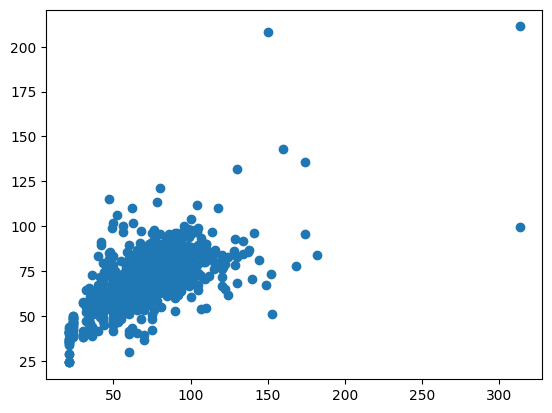

In [4]:
sgdr = SGDRegressor(max_iter=1000,alpha=0.2,eta0=0.005)
sgdr.fit(train_impute_X1_int_scaled,train_impute_Y1.to_numpy())
yhat_train = sgdr.predict(train_impute_X1_int_scaled)
yhat_test = sgdr.predict(test_impute_X1_int_scaled)

test_impute_X1["LotFrontage"]=yhat_test
test_impute_X1["SalePrice"]=train_data.loc[test_impute_X1["Id"]-1]["SalePrice"]
test_impute_X1=test_impute_X1[train_data.columns]

print(r2_score(train_impute_Y1.to_numpy(),yhat_train))
plt.scatter(train_impute_Y1.to_numpy(),yhat_train)
plt.show()

In [5]:
train_data = train_data.merge(test_impute_X1.loc[:,('Id','LotFrontage')],how='left',on='Id')
train_data['LotFrontage_x']=train_data['LotFrontage_x'].fillna(train_data['LotFrontage_y'])
train_data = train_data.drop('LotFrontage_y',axis=1)
train_data = train_data.rename(columns={"LotFrontage_x":"LotFrontage"})

In [6]:
# Data dropped which will be Imputed and rest fill with mean or NA 
test_Id_Lot = test_data.loc[:,('Id','LotFrontage')]
test_data = test_data.drop('LotFrontage',axis=1)
# Handling naN values in numeric train (LotFrontage and GarageYrBlt) and test data
train_data = train_data.fillna(value=dict(train_data.select_dtypes(include=['int','float']).mean()))
test_data  = test_data.fillna(value=dict(train_data.select_dtypes(include=['int','float']).mean()))

# Converting naN values in object data to NA as it means amenity doesn't exit but the data does exit
train_data = train_data.fillna(value='NA')
test_data = test_data.fillna(value='NA')

In [7]:
#Imputing LotFrontage for test_data
test_data =test_data.merge(test_Id_Lot,how='left',on='Id')
test_data = test_data[train_data.columns[0:80]]

#Dataset broken for imputation of test_data
test_impute_X2 = test_data[test_data["LotFrontage"].isnull()]
test_impute_X2 = test_impute_X2.drop(columns=['LotFrontage'])

test_impute_X2_int = test_impute_X2.select_dtypes(include=['int','float'])
test_impute_X2_int_scaled = scaler.transform(test_impute_X2_int.loc[:,(test_impute_X2_int.columns!='Id')])

yhat_X2_test = sgdr.predict(test_impute_X2_int_scaled)

test_impute_X2["LotFrontage"]=yhat_X2_test
test_impute_X2=test_impute_X2[test_data.columns]

In [8]:
# Merging Imputed data back to test_data
test_data = test_data.merge(test_impute_X2.loc[:,('Id','LotFrontage')],how='left',on='Id')
test_data['LotFrontage_x']=test_data['LotFrontage_x'].fillna(test_data['LotFrontage_y'])
test_data = test_data.drop('LotFrontage_y',axis=1)
test_data = test_data.rename(columns={"LotFrontage_x":"LotFrontage"})

In [9]:
# Categorical Data: One-hot Encoding list
Categorical_list1 = list(train_data.select_dtypes(include=['object']).columns)
train_data = pd.get_dummies(train_data,prefix=Categorical_list1,columns=Categorical_list1,dtype=int)
Categorical_list2 = list(test_data.select_dtypes(include=['object']).columns)
test_data = pd.get_dummies(test_data,prefix=Categorical_list2,columns=Categorical_list2,dtype=int)

In [10]:
train_X = train_data.loc[:,(train_data.columns != 'SalePrice') & (train_data.columns != 'Id')]
train_Y = train_data['SalePrice']
test_X = test_data.loc[:,test_data.columns != 'Id']

In [11]:
# Inserting the features in test data which are not present in test data
In_Train_Not_Test = []
for i in train_X.columns:
    if i not in test_X.columns:
        test_X.insert(test_X.shape[1],i,0)
        In_Train_Not_Test.append(i)

In_Test_Not_Train = []     
for i in test_X.columns:
    if i not in train_X.columns:
        In_Test_Not_Train.append(i)

# Dropping the features in test data which are not present in train data
test_X = test_X.drop(columns=In_Test_Not_Train)
# Making the column order same in feature vectors
test_X = test_X[train_X.columns]

In [12]:
xgb_model = XGBRegressor(eval_metric=mean_squared_log_error, random_state = 50)

In [13]:
parameters = {
    'max_depth': range(3,6,1),
    'n_estimators' : range(100,500,50),
    'learning_rate' : [0.05,0.1,0.15],
    'reg_lambda' : range(2,10,2)
}
# parameters = {
#     'max_depth': range(2,5,1),
#     'n_estimators' : range(50,150,50), 
# }

In [14]:
grid_search = GridSearchCV(estimator = xgb_model, param_grid=parameters, scoring='neg_mean_squared_log_error',cv=10,n_jobs=10,verbose=True)

In [15]:
grid_search.fit(train_X,train_Y)

Fitting 10 folds for each of 288 candidates, totalling 2880 fits


GridSearchCV(cv=10,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False,
                                    eval_metric=<function mean_squared_log_error at 0x7e4340639ab0>,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    inte...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=50, ...),
             n_jobs=10,
             param_grid={'learning_rate': [0.05, 0.1, 0.15],
                         'max_depth': range(3, 6),
                         'n_estimators': range(100, 500, 50),
                         'reg_lambda': range(2, 10, 2)},
             scoring='neg_mean_squared_log_error', verbose=True)

The RMSE of log2 of values on training data is: 0.08752240284551407
R2 value on train data: 0.986056942067975


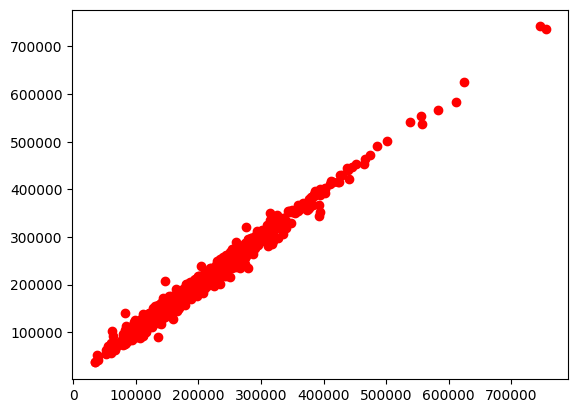

In [16]:
yhat_train_XGB = grid_search.best_estimator_.predict(train_X)
RMSE_log2_train = math.sqrt(((np.log2(train_Y) - np.log2(yhat_train_XGB))**2).sum()/len(train_Y))
print(f"The RMSE of log2 of values on training data is: {RMSE_log2_train}")
print(f"R2 value on train data: {r2_score(train_Y,yhat_train_XGB)}")
plt.scatter(train_Y,yhat_train_XGB,c='r')
plt.show()

In [17]:
grid_search.best_params_

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 450, 'reg_lambda': 4}

In [18]:
yhat_test_XGB = grid_search.best_estimator_.predict(test_X)
Submission_Predictions = pd.DataFrame(yhat_test_XGB,columns=['SalePrice'])
Submission_Predictions.insert(0,"Id",test_data['Id'])


In [19]:
Submission_Predictions.to_csv('submission.csv',index=False)